# dask

> Convenient functions for dask

In [ ]:
#| default_exp cli/dask_

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import math
import itertools
import concurrent
import logging
from pathlib import Path

import numpy as np
from dask import array as da
from dask import delayed
import zarr

from moraine.chunk_ import fill_slice as _fill_slice
from moraine.chunk_ import all_chunk_slices, all_chunk_slices_with_overlap
from moraine.cli.logging import mc_logger_

In [ ]:
#| export
def _one_chunk_slices_and_out_shape(data_zarr,slices):
    '''divide input slices into slices of every zarr chunk
    and return the shape of subdata to be reade'''
    zarr_1chunk_slice = []
    out_1chunk_slice = []
    out_shape = []
    for i in range(len(slices)):
        chunk_size = data_zarr.chunks[i]
        shape = data_zarr.shape[i]
        zarr_slices = slices[i]
        start = zarr_slices.start
        stop = zarr_slices.stop
        out_shape.append(stop-start)

        start_ = math.floor(start/chunk_size)*chunk_size    
        zarr_1dim_bound = np.arange(start_,stop+chunk_size,chunk_size)
        zarr_1dim_bound[0] = start
        if zarr_1dim_bound[-1] > stop: zarr_1dim_bound[-1] = stop
        out_1dim_bound = zarr_1dim_bound-start

        zarr_1chunk_1dim_slice = []
        out_1chunk_1dim_slice = []
        for j in range(zarr_1dim_bound.shape[0]-1):
            zarr_1chunk_1dim_slice.append(slice(zarr_1dim_bound[j],zarr_1dim_bound[j+1]))
            out_1chunk_1dim_slice.append(slice(out_1dim_bound[j],out_1dim_bound[j+1]))

        zarr_1chunk_slice.append(zarr_1chunk_1dim_slice)
        out_1chunk_slice.append(out_1chunk_1dim_slice)

    zarr_1chunk_slice = list(itertools.product(*zarr_1chunk_slice))
    out_1chunk_slice = list(itertools.product(*out_1chunk_slice))

    return zarr_1chunk_slice, out_1chunk_slice, tuple(out_shape)

In [ ]:
#| export
def _read_one_chunk(data_zarr,out,zarr_slices,out_slices):
    out[out_slices] = data_zarr[zarr_slices]

In [ ]:
#| export
def parallel_read_zarr(data_zarr,slices,thread_pool_size=None,fill_slice=True):
    if fill_slice:
        slices = _fill_slice(data_zarr.shape,slices)
    zarr_1chunk_slices, out_1chunk_slices, out_shape = \
    _one_chunk_slices_and_out_shape(data_zarr,slices)
    # global out
    out = np.empty(out_shape,dtype=data_zarr.dtype)

    with concurrent.futures.ThreadPoolExecutor(thread_pool_size) as executor:
        for zarr_1chunk_slice,out_1chunk_slice in zip(zarr_1chunk_slices,out_1chunk_slices):
            future = executor.submit(_read_one_chunk,data_zarr,out,zarr_1chunk_slice,out_1chunk_slice)
    return out

In [ ]:
#| hide
data = np.random.rand(13165,68467,4)
data = data+1j*data
data = data.astype(np.complex64)
data_path = './dask_/data.zarr'
data_zarr = zarr.open(data_path,mode='w',shape=data.shape,dtype=data.dtype,chunks=(50,68467,1))
data_zarr[:] = data

In [ ]:
rslc_path = '/users/kangl/work/insar_denoising/NorthDallas_34_105_2019_ascending/moraine/load_data/rslc.zarr/'
rslc_zarr = zarr.open(rslc_path,mode='r')

In [ ]:
rslc_zarr.shape

(13165, 68467, 27)

In [ ]:
rslc_zarr.chunks

(50, 68467, 1)

In [ ]:
data_path = './dask_/data.zarr'
data_zarr = zarr.open(data_path,mode='r')

In [ ]:
%%time
out = parallel_read_zarr(data_zarr,(slice(0,13165),slice(0,68467),slice(0,1)))

CPU times: user 18.8 s, sys: 5.84 s, total: 24.6 s
Wall time: 1.69 s


In [ ]:
%%time
out = data_zarr[:,:,0:1]

CPU times: user 17 s, sys: 1.83 s, total: 18.8 s
Wall time: 2.27 s


In [ ]:
%%time
out = parallel_read_zarr(rslc_zarr,(slice(0,13165),slice(0,68467),slice(0,1)))

CPU times: user 5.01 s, sys: 6.06 s, total: 11.1 s
Wall time: 1.32 s


In [ ]:
%%time
out = rslc_zarr[:,:,0:1]

CPU times: user 3.36 s, sys: 2.4 s, total: 5.76 s
Wall time: 1.49 s


In [ ]:
# test with 128 core to see if parallel read really accelerate
# in version 2, parallel_read takes 760 ms, directly read takes 3.5 s
# 目前还是不是很清楚为什么升级到v3以后速度上有这些差异， 
# v2版本的数据为什么直接读取速度会比v3快？
# 为什么parallel read 不会取得明显的加速效果？
# 这些问题都需要等待zarr v3 稳定以后再说，包括plot 要不要用sharding，暂时先搁置

In [ ]:
np.testing.assert_array_equal(data_zarr[:,:,2:3],parallel_read_zarr(data_zarr,(slice(0,13165),slice(0,68467),slice(2,3))))

In [ ]:
np.testing.assert_array_equal(data_zarr[345:3845,299:29394,2:3],parallel_read_zarr(data_zarr,(slice(345,3845),slice(299,29394),slice(2,3))))

In [ ]:
#| export
def dask_from_zarr(
    data_path:str,
    parallel_dims:int|tuple=None,
    chunks:tuple=None,
):
    # chunks provide more control of chunking compared with parallel_dims
    data_zarr = zarr.open(data_path,mode='r')
    if chunks is None: chunks = data_zarr.chunks
    chunks = list(chunks)
    if parallel_dims is not None:
        if isinstance(parallel_dims,int):
            parallel_dims = (parallel_dims,)

        for pdim in parallel_dims:
            chunks[pdim] = data_zarr.shape[pdim]
    for i in range(len(chunks)):
        if chunks[i] <0: chunks[i] = data_zarr.shape[i]
    chunks = tuple(chunks)

    slices = all_chunk_slices(data_zarr.shape,chunks)

    _p_read_zarr_delayed = delayed(parallel_read_zarr,pure=True,nout=1)
    out_delayed = np.empty(len(slices),dtype=object)
    for i in range(len(slices)):
        slices_i = _fill_slice(data_zarr.shape,slices[i])
        out_delayed[i] = _p_read_zarr_delayed(data_zarr,slices_i,fill_slice=False)
        shape = []
        for slice_ in slices_i:
            shape.append(slice_.stop-slice_.start)
        shape = tuple(shape)
        out_delayed[i] = da.from_delayed(out_delayed[i],shape=shape,dtype=data_zarr.dtype,meta=np.array((),dtype=data_zarr.dtype))

    nchunks = [math.ceil(shape/chunk) for chunk, shape in zip(chunks,data_zarr.shape)]
    out_delayed = out_delayed.reshape(tuple(nchunks))
    data_darr = da.block(out_delayed.tolist())
    return data_darr

In [ ]:
data_darr = dask_from_zarr('dask_/data.zarr/',parallel_dims=(0,1))
data_darr

dask.array<concatenate, shape=(13165, 68467, 4), dtype=complex64, chunksize=(13165, 68467, 1), chunktype=numpy.ndarray>

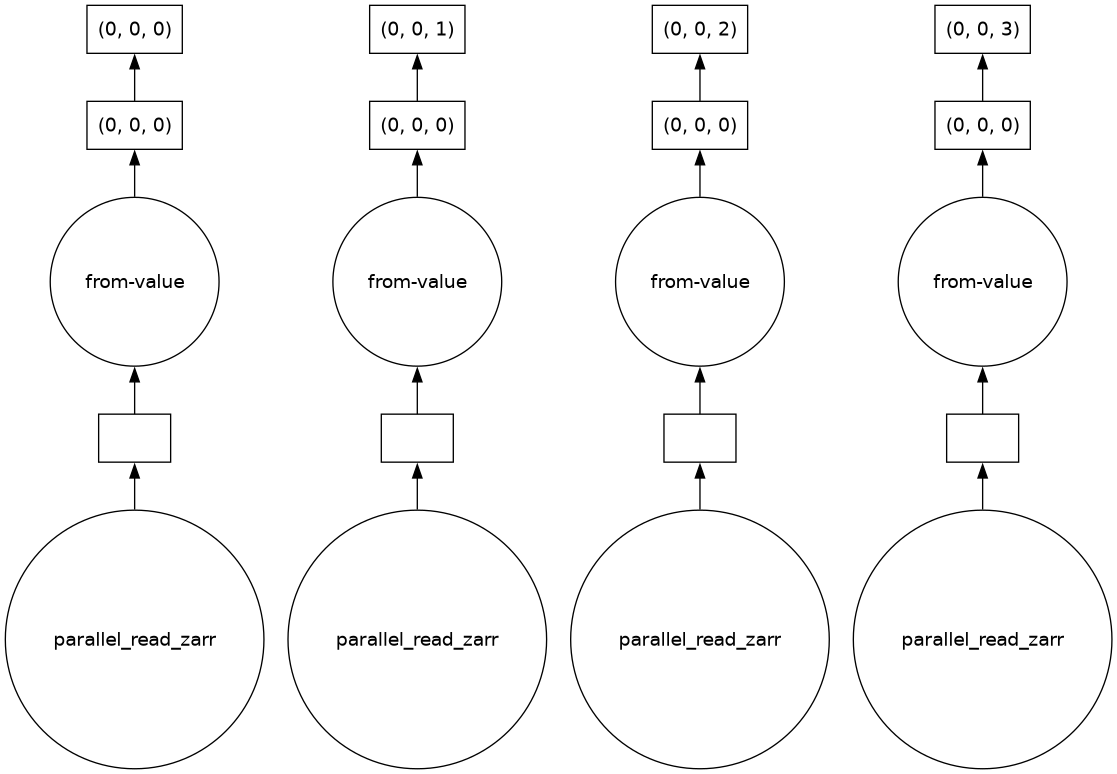

In [ ]:
data_darr.visualize()

In [ ]:
rslc_darr = dask_from_zarr('raw/rslc.zarr/',chunks=(1000,1000,1))
rslc_darr

dask.array<concatenate, shape=(2500, 1834, 17), dtype=complex64, chunksize=(1000, 1000, 1), chunktype=numpy.ndarray>

In [ ]:
np.testing.assert_array_equal(rslc_darr.compute(),zarr.open('raw/rslc.zarr',mode='r')[:])

In [ ]:
#| export
def dask_from_zarr_overlap(
    data_path:str,
    chunks:tuple,
    depth:tuple,
):
    # chunks provide more control of chunking compared with parallel_dims
    data_zarr = zarr.open(data_path,mode='r')

    chunks = list(chunks)
    for i in range(len(chunks)):
        if chunks[i] <0: chunks[i] = data_zarr.shape[i]
    chunks = tuple(chunks)

    slices = all_chunk_slices_with_overlap(data_zarr.shape,chunks,depth)

    _p_read_zarr_delayed = delayed(parallel_read_zarr,pure=True,nout=1)
    out_delayed = np.empty(len(slices),dtype=object)
    for i in range(len(slices)):
        slices_i = _fill_slice(data_zarr.shape,slices[i])
        out_delayed[i] = _p_read_zarr_delayed(data_zarr,slices_i,fill_slice=False)
        shape = []
        for slice_ in slices_i:
            shape.append(slice_.stop-slice_.start)
        shape = tuple(shape)
        out_delayed[i] = da.from_delayed(out_delayed[i],shape=shape,dtype=data_zarr.dtype,meta=np.array((),dtype=data_zarr.dtype))

    nchunks = [math.ceil(shape/chunk) for chunk, shape in zip(chunks,data_zarr.shape)]
    out_delayed = out_delayed.reshape(tuple(nchunks))
    data_darr = da.block(out_delayed.tolist())
    return data_darr

In [ ]:
rslc_darr = dask_from_zarr('raw/rslc.zarr/',chunks=(1000,1000,2))
rslc_overlap_darr_ = da.overlap.overlap(rslc_darr,depth=(5,5,0),boundary = {0:'none',1:'none',2:'none'})
rslc_overlap_darr = dask_from_zarr_overlap('raw/rslc.zarr/',chunks=(1000,1000,2),depth=(5,5,0))
rslc_overlap_darr

dask.array<concatenate, shape=(2520, 1844, 17), dtype=complex64, chunksize=(1010, 1005, 2), chunktype=numpy.ndarray>

In [ ]:
np.testing.assert_array_equal(rslc_overlap_darr_.compute(),rslc_overlap_darr.compute())

In [ ]:
#| export
#| hide
class ZarrDir():
    def __init__(self,zarr_path_list:list):
        self.zarr_path_list = zarr_path_list
        zarr0 = zarr.open(self.zarr_path_list[0])
        self.chunksize = zarr0.chunks
        self.ndim = zarr0.ndim
        self.dtype = zarr0.dtype
        
        dim0_shape = 0
        dim0_chunks = []
        for zarr_path in self.zarr_path_list:
            data_zarr = zarr.open(zarr_path,mode='r')
            assert data_zarr.chunks[0] == data_zarr.shape[0]
            assert data_zarr.chunks[1:] == (1,)*(data_zarr.ndim-1)
            dim0_shape += data_zarr.shape[0]
            dim0_chunks.append(data_zarr.chunks[0])
        self.shape = (dim0_shape,*zarr0.shape[1:])
        self.dim0_chunks = tuple(dim0_chunks)

    @classmethod
    def from_dir(cls,zarr_dir):
        zarr_dir = Path(zarr_dir)
        zarr_path_list = sorted(zarr_dir.glob('*.zarr'),key=lambda path: int(path.stem)) # if one chunk is missing, it is ok
        return cls(zarr_path_list)

In [ ]:
#| export
#| hide
def _parallel_read_pc_dir(
    zarr_dir, # zarr_dir object
    idx, # index for dim 1,2,...
    thread_pool_size=None):
    # global out
    if isinstance(idx,int):
        idx = (idx,)
    out = np.empty(zarr_dir.shape[0],dtype=zarr_dir.dtype)
    out_slices = []
    start = 0
    for chunk in zarr_dir.dim0_chunks:
        end = start+chunk
        out_slices.append(slice(start,end))
        start = end

    def _read_one_zarr_one_chunk(zarr_path,out,idx,out_slice):
        data_zarr = zarr.open(zarr_path,mode='r')
        idx = (slice(None),*idx)
        out[out_slice] = data_zarr[idx]

    with concurrent.futures.ThreadPoolExecutor(thread_pool_size) as executor:
        for zarr_path,out_slice in zip(zarr_dir.zarr_path_list,out_slices):
            future = executor.submit(_read_one_zarr_one_chunk,zarr_path,out,idx,out_slice)
    return out

In [ ]:
pc_data1 = np.random.rand(32,10).astype(np.float32)
pc_data2 = np.random.rand(64,10).astype(np.float32)

pc_zarr1 = zarr.open('dask_/pc/1.zarr',mode='w',shape=pc_data1.shape,dtype=pc_data1.dtype,chunks=(32,1))
pc_zarr2 = zarr.open('dask_/pc/2.zarr',mode='w',shape=pc_data2.shape,dtype=pc_data2.dtype,chunks=(64,1))
pc_zarr1[:] = pc_data1
pc_zarr2[:] = pc_data2

In [ ]:
zarr_dir = ZarrDir.from_dir('dask_/pc')
np.testing.assert_array_equal(np.concatenate((pc_data1,pc_data2),axis=0)[:,2],_parallel_read_pc_dir(zarr_dir,2))

In [ ]:
#| export
#| hide
def _dask_from_pc_zarr_dir(zarrs):
    if isinstance(zarrs,list):
        zarr_dir = ZarrDir(zarrs)
    else:
        zarr_dir = ZarrDir.from_dir(zarrs)
    out_shape = zarr_dir.shape[1:]
    out_chunk_shape = (1,)*(zarr_dir.ndim-1)
    out_delayed = np.empty((1,*out_shape),dtype=object)
    parallel_read_delayed = delayed(_parallel_read_pc_dir,pure=True,nout=1)
    with np.nditer(out_delayed,flags=['multi_index','refs_ok'], op_flags=['readwrite']) as arr_it:
        for arr_block in arr_it:
            idx = arr_it.multi_index
            out_delayed[idx] = parallel_read_delayed(zarr_dir,idx[1:])
            out_delayed[idx] = da.from_delayed(out_delayed[idx],shape=(zarr_dir.shape[0],),meta=np.array((),dtype=zarr_dir.dtype))
            out_delayed[idx] = out_delayed[idx].reshape((zarr_dir.shape[0],*out_chunk_shape))
    return da.block(out_delayed.tolist())

In [ ]:
pc_darr = _dask_from_pc_zarr_dir('dask_/pc')
np.testing.assert_array_equal(np.concatenate((pc_data1,pc_data2),axis=0),pc_darr.compute())

In [ ]:
#| export
def _write_one_chunk(data_zarr,data,zarr_slices,data_slices):
    data_zarr[zarr_slices] = data[data_slices]

In [ ]:
#| export
def parallel_write_zarr(data,data_zarr,slices,thread_pool_size=None,fill_slice=True):
    if fill_slice:
        slices = _fill_slice(data_zarr.shape,slices)
    zarr_1chunk_slices, data_1chunk_slices = \
    _one_chunk_slices_and_out_shape(data_zarr,slices)[:2]

    with concurrent.futures.ThreadPoolExecutor(thread_pool_size) as executor:
        for zarr_1chunk_slice,data_1chunk_slice in zip(zarr_1chunk_slices,data_1chunk_slices):
            future = executor.submit(_write_one_chunk,data_zarr,data,zarr_1chunk_slice,data_1chunk_slice)

In [ ]:
out_rslc_path = './dask_/rslc.zarr'
#rslc_path = './dask_/data.zarr/'
rslc_path = '/users/kangl/work/insar_denoising/NorthDallas_34_105_2019_ascending/moraine/load_data/rslc.zarr/'
rslc_zarr = zarr.open(rslc_path,mode='r')
one_rslc = rslc_zarr[slice(0,13165),slice(0,68467),slice(0,1)]

In [ ]:
out_rslc_zarr = zarr.open(out_rslc_path,mode='w',shape=rslc_zarr.shape,dtype=rslc_zarr.dtype,chunks=rslc_zarr.chunks)

In [ ]:
%%time
out_rslc_zarr[slice(0,13165),slice(0,68467),slice(0,1)] = one_rslc

CPU times: user 10.8 s, sys: 4.69 s, total: 15.5 s
Wall time: 2.06 s


In [ ]:
%%time
parallel_write_zarr(one_rslc,out_rslc_zarr,(slice(0,13165),slice(0,68467),slice(0,1)))

CPU times: user 11.2 s, sys: 11.1 s, total: 22.4 s
Wall time: 1.81 s


In [ ]:
# also test here
# 但是现在看起来用不用parallel对于速度没啥大的影响

In [ ]:
#| export
def _all_chunk_slices_except_pdims(data_zarr, pdims):
    out_slices = []
    for i in range(data_zarr.ndim):
        if i in pdims:
            slice_1dim = [slice(None)]
        else:
            shape = data_zarr.shape[i]
            chunk = data_zarr.chunks[i]
            if chunk <0: chunk=shape

            bound_1dim = np.arange(0,shape+chunk,chunk)
            if bound_1dim[-1] > shape: bound_1dim[-1] = shape

            slice_1dim = []
            for j in range(bound_1dim.shape[0]-1):
                slice_1dim.append(slice(bound_1dim[j],bound_1dim[j+1]))
        out_slices.append(slice_1dim)
    out_slices = list(itertools.product(*out_slices))
    return out_slices

In [ ]:
#| export
@mc_logger_
def dask_to_zarr(data_darr,url,chunks,path=None,log_zarr=True):
    logger = logging.getLogger(__name__)
    if isinstance(url, zarr.Array):
        data_zarr = url
        if log_zarr:
            logger.zarr_info(path,data_zarr)
    else:
        data_zarr = zarr.open(url,mode='w',shape=data_darr.shape,dtype=data_darr.dtype,chunks=chunks)
        if log_zarr:
            logger.zarr_info(url,data_zarr)
    pdims = []
    for i in range(data_darr.ndim):
        if data_darr.chunksize[i] != data_zarr.chunks[i]:
            assert data_darr.chunksize[i] == data_darr.shape[i], "dask array is not properly rechunked."
            pdims.append(i)
    pdims = tuple(pdims)
    slices = _all_chunk_slices_except_pdims(data_zarr,pdims)
    n_slices = len(slices)

    _p_write_zarr_delayed = delayed(parallel_write_zarr,pure=True,nout=0)
    out_delayed = np.empty(n_slices,dtype=object)
    data_darr_delayed = data_darr.to_delayed()
    data_darr_delayed = data_darr_delayed.reshape(n_slices)
    for i in range(n_slices):
        slices_i = _fill_slice(data_zarr.shape,slices[i])
        out_delayed[i] = _p_write_zarr_delayed(data_darr_delayed[i],data_zarr,slices_i,fill_slice=False)
        out_delayed[i] = da.from_delayed(out_delayed[i],shape=(1,),dtype=int)

    return da.block(out_delayed.tolist())

In [ ]:
rslc_darr = dask_from_zarr('raw/rslc.zarr/',parallel_dims=(1,2))

In [ ]:
rslc_darr = rslc_darr.persist()

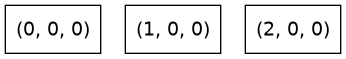

In [ ]:
rslc_darr.visualize()

In [ ]:
rslc_darr

dask.array<concatenate, shape=(2500, 1834, 17), dtype=complex64, chunksize=(1000, 1834, 17), chunktype=numpy.ndarray>

In [ ]:
out_delayed = dask_to_zarr(rslc_darr,'./dask_/rslc.zarr/',chunks=(rslc_darr.chunksize[0],rslc_darr.shape[1],1))

In [ ]:
da.compute(out_delayed)

(array([], dtype=float64),)

In [ ]:
np.testing.assert_array_equal(zarr.open('./dask_/rslc.zarr',mode='r')[:], zarr.open('./raw/rslc.zarr',mode='r')[:])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()